# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering` and `DBSCAN`
        

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
dataset_url = "Wholesale-customers-data.csv"
df = pd.read_csv(dataset_url)
df.shape

(440, 8)

In [3]:
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

## 2. Observe the data distributions

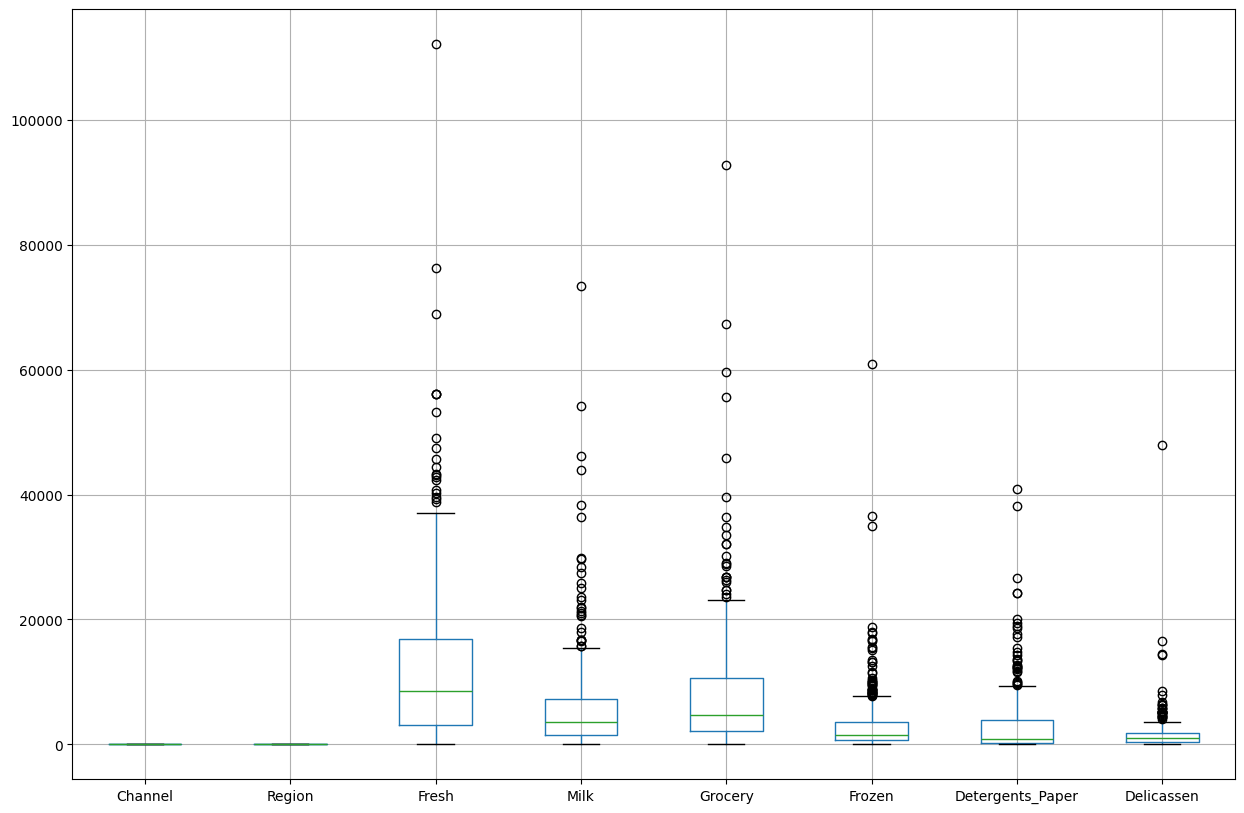

In [4]:
plt.figure(figsize=(15, 10))
df.boxplot()
plt.show()

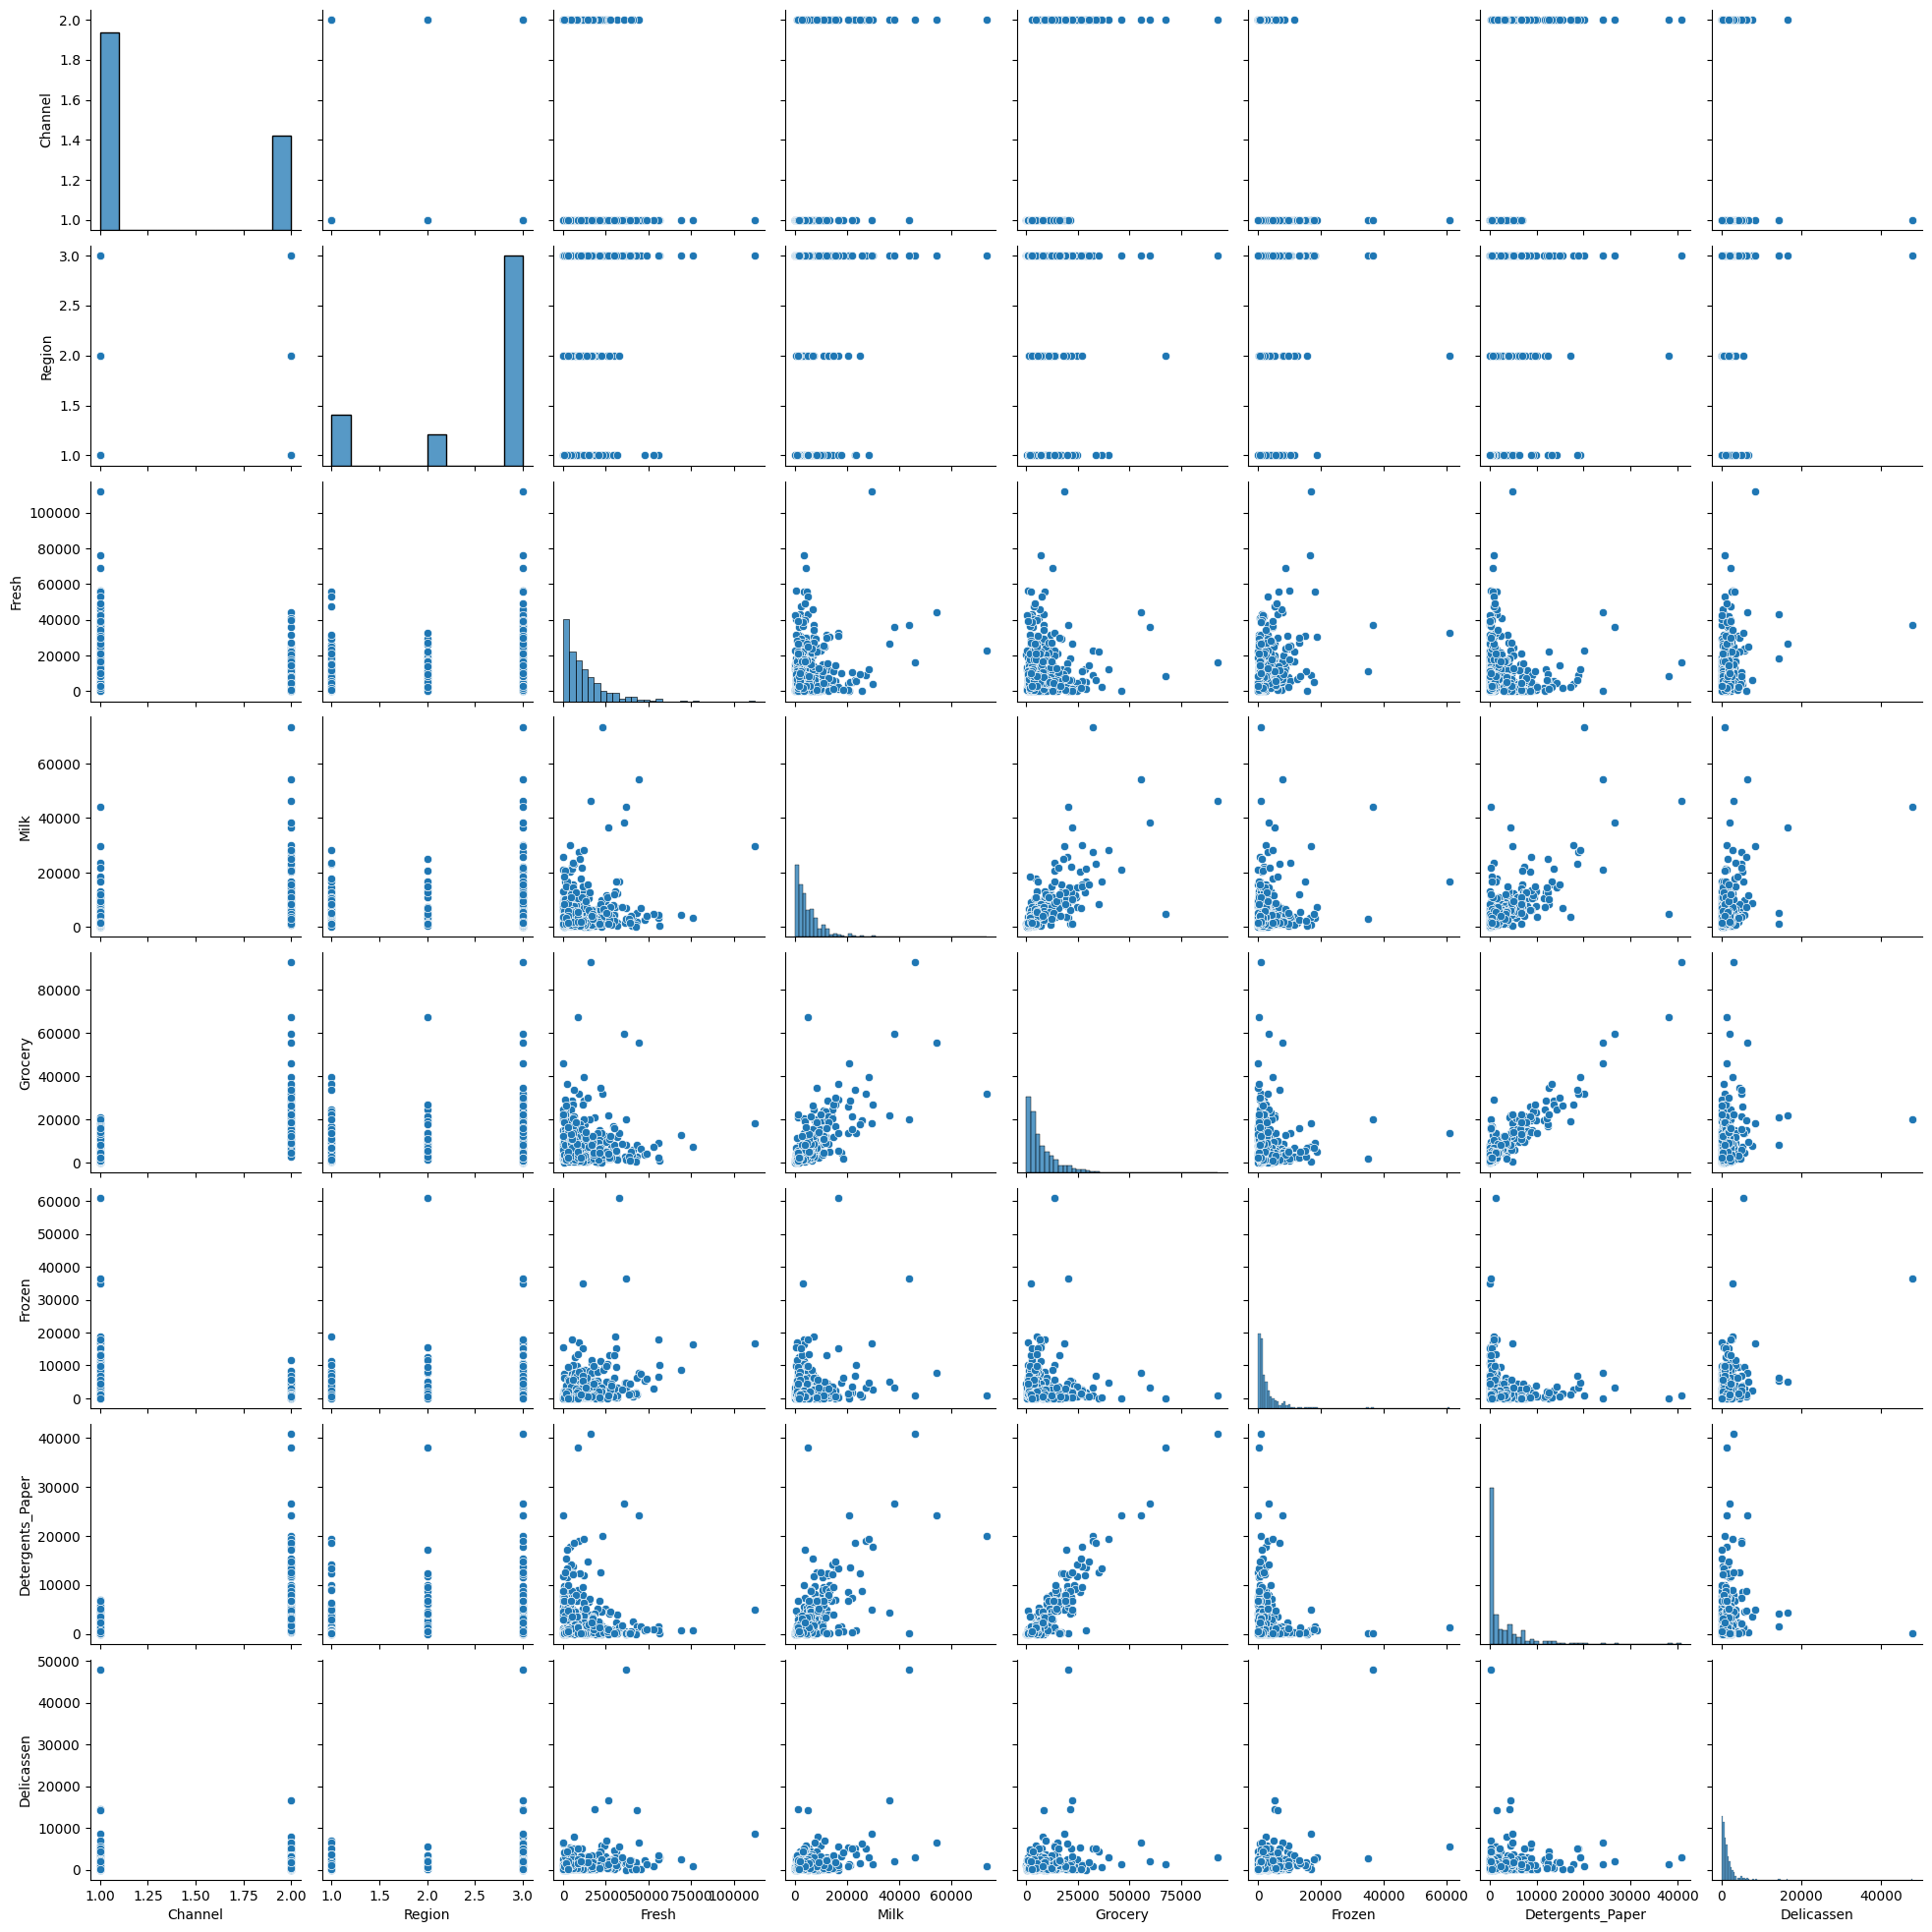

In [5]:
sns.pairplot(df)
plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1`

In [3]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

dataset_url = "Wholesale-customers-data.csv"
df = pd.read_csv(dataset_url)

transformed_df = df.copy()
print(df.head())

pt = PowerTransformer()
transformed_df[transformed_df.columns[2:]] = pt.fit_transform(transformed_df[transformed_df.columns[2:]])
print(transformed_df.head())

scaler = MinMaxScaler(feature_range=(0, 1))
transformed_df[transformed_df.columns] = scaler.fit_transform(transformed_df[transformed_df.columns])
transformed_df.head()


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
   Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0        2       3  0.413012  0.979454  0.394901 -1.457973          0.620530   
1        2       3 -0.110911  0.995243  0.628376  0.080081          0.751556   
2        2       3 -0.195814  0.888063  0.410688  0.332499          0.793104   
3        1       3  0.458126 -0.965336 -0.154740  1.173953         -0.372736   
4        2       3  1.028870  0.412660  0.346961  0.742061          0.367767   

   Delicassen  
0    0.338074  
1    0.602222

Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0      1.0     1.0  0.501828  0.667606  0.625238  0.208640          0.649941   
1      1.0     1.0  0.414266  0.670028  0.655690  0.458800          0.674852   
2      1.0     1.0  0.400077  0.653586  0.627297  0.499856          0.682752   
3      0.0     1.0  0.509368  0.369264  0.553550  0.636716          0.461095   
4      1.0     1.0  0.604755  0.580657  0.618985  0.566470          0.601884   

   Delicassen  
0    0.412016  
1    0.445663  
2    0.654292  
3    0.446485  
4    0.590255

Show the result of the transformation

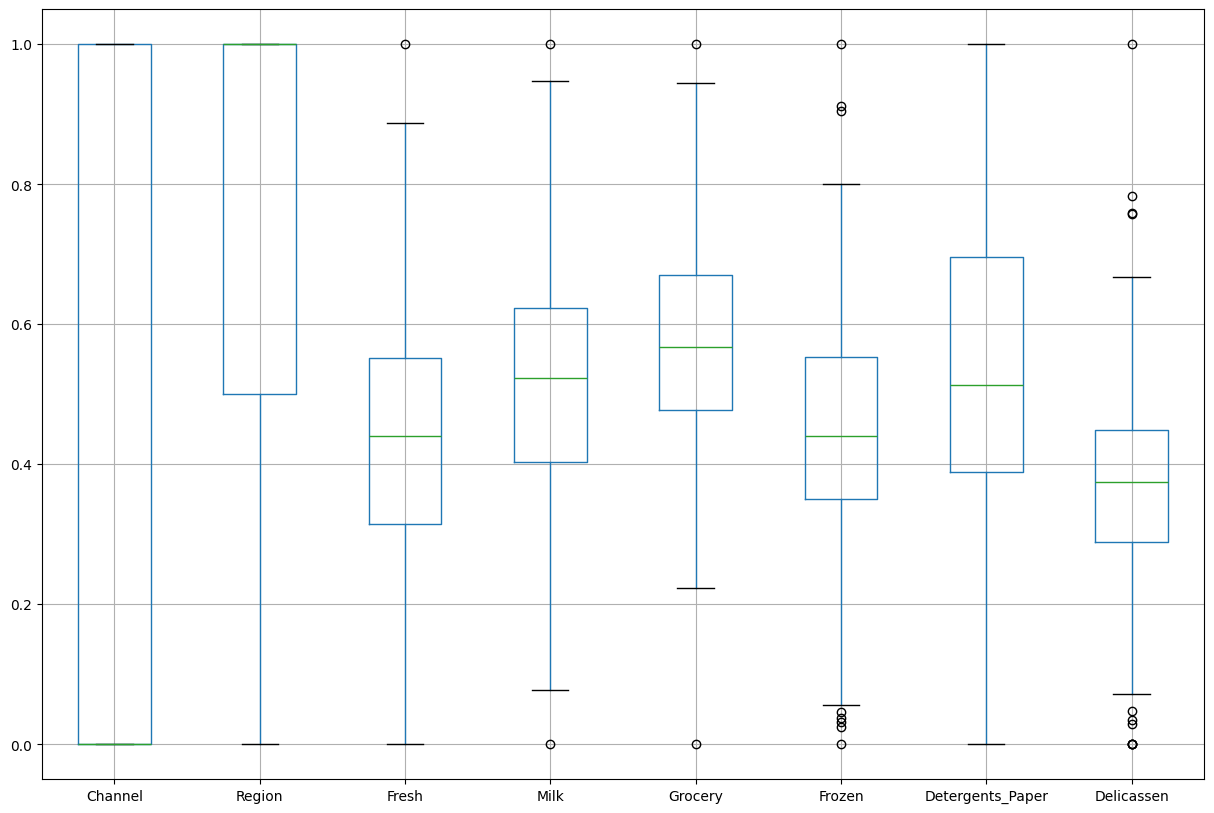

In [4]:
plt.figure(figsize=(15, 10))
transformed_df.boxplot()
plt.show()

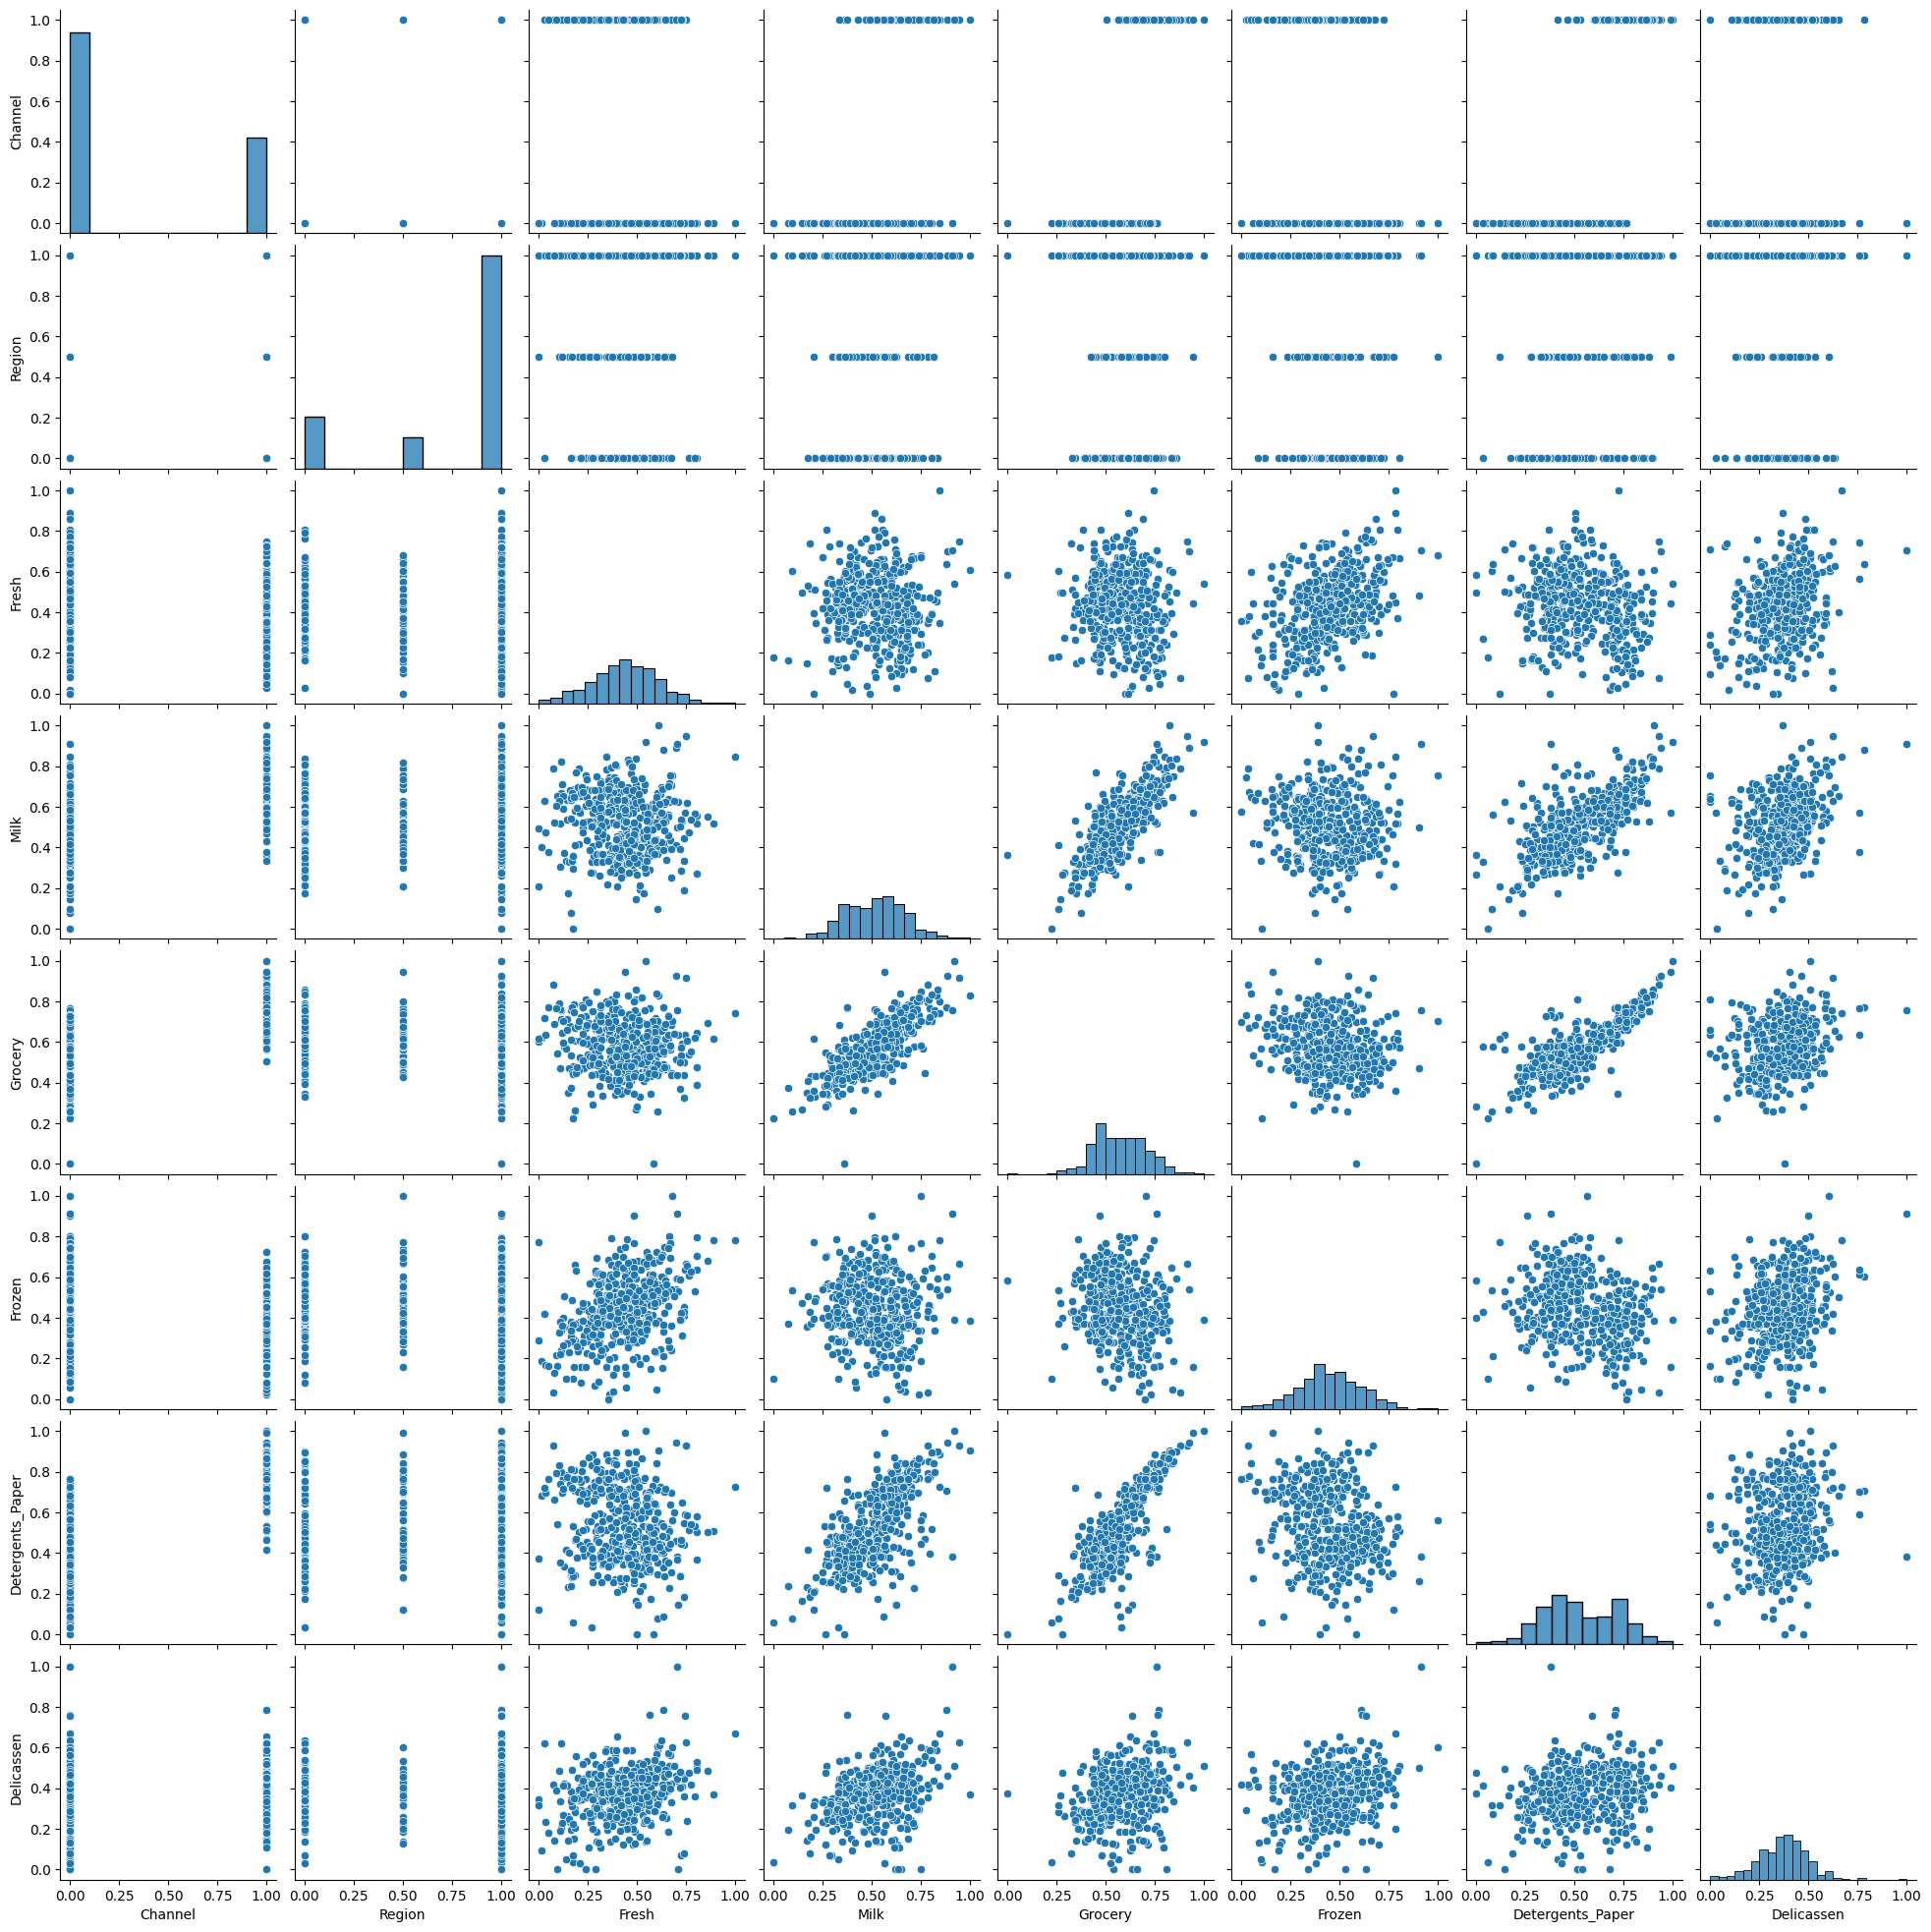

In [5]:
sns.pairplot(transformed_df)
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [6]:
results = pd.DataFrame(columns=["labels", "inertia", "silhouette_score"])

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(k, random_state=random_state)
    # estimator = kmeans.fit(transformed_df)
    # labels = kmeans.predict(transformed_df)
    labels = kmeans.fit_predict(transformed_df)
    # results.append((labels, estimator.inertia_, silhouette_score(transformed_df, labels)))
    results.loc[len(results)] = [
        labels,
        kmeans.inertia_,
        silhouette_score(transformed_df, labels)
    ]

results

labels     inertia  \
0  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  113.143465   
1  [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...   69.723925   
2  [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...   54.491873   
3  [0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...   48.404184   
4  [0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...   44.704430   
5  [0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...   39.955306   
6  [7, 7, 7, 2, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, ...   37.244207   
7  [0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, ...   35.990290   
8  [0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, ...   34.666883   

   silhouette_score  
0          0.499350  
1          0.498854  
2          0.493629  
3          0.338308  
4          0.331934  
5          0.325959  
6          0.261743  
7          0.259284  
8          0.237989

## 4. Plot __inertia__ and __silhouette score__ versus `k`

In [8]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()
    plt.show()

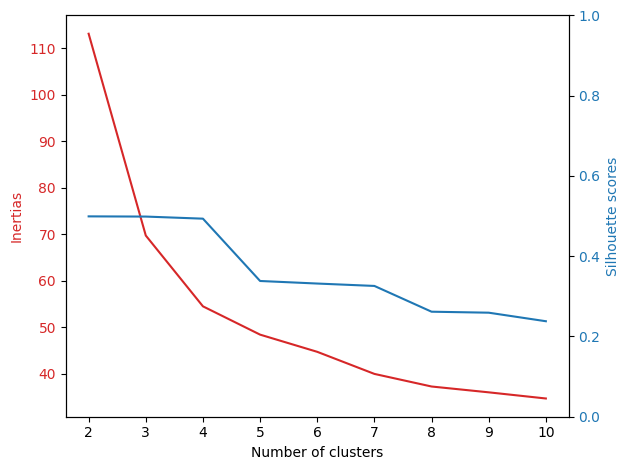

In [9]:
two_plots(
    x=k_range,
    y1=results["inertia"],
    y2=results["silhouette_score"],
    xlabel='Number of clusters',
    y1label='Inertias',
    y2label='Silhouette scores'
)

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [10]:
k=4
kmeans = KMeans(k, random_state=random_state)
km_labels = kmeans.fit_predict(transformed_df)
kmeans.inertia_, silhouette_score(transformed_df, labels)

(54.49187342996634, 0.2379893243806764)

Show the distribution of samples in the clusters with a pie chart

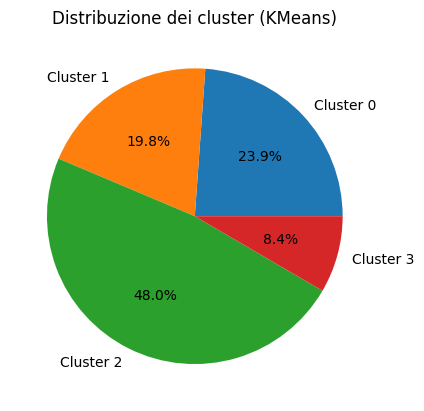

In [11]:
clust_sizes_km = np.unique(km_labels, return_counts=True)
# pie chart
plt.pie(
    clust_sizes_km[1],
    labels=[f"Cluster {i}" for i in clust_sizes_km[0]],
    autopct='%1.1f%%', # percentuali delle fette
)
plt.title("Distribuzione dei cluster (KMeans)")
plt.show()

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [13]:
from sklearn.cluster import AgglomerativeClustering
import pprint

In [14]:
cluster_range = range(2,11)
parameters = [{
    "n_clusters": cluster_range,
    "linkage": ["ward", "complete", "average", "single"]
}]
pg = ParameterGrid(parameters)
pprint.pprint(list(pg))

[{'linkage': 'ward', 'n_clusters': 2},
 {'linkage': 'ward', 'n_clusters': 3},
 {'linkage': 'ward', 'n_clusters': 4},
 {'linkage': 'ward', 'n_clusters': 5},
 {'linkage': 'ward', 'n_clusters': 6},
 {'linkage': 'ward', 'n_clusters': 7},
 {'linkage': 'ward', 'n_clusters': 8},
 {'linkage': 'ward', 'n_clusters': 9},
 {'linkage': 'ward', 'n_clusters': 10},
 {'linkage': 'complete', 'n_clusters': 2},
 {'linkage': 'complete', 'n_clusters': 3},
 {'linkage': 'complete', 'n_clusters': 4},
 {'linkage': 'complete', 'n_clusters': 5},
 {'linkage': 'complete', 'n_clusters': 6},
 {'linkage': 'complete', 'n_clusters': 7},
 {'linkage': 'complete', 'n_clusters': 8},
 {'linkage': 'complete', 'n_clusters': 9},
 {'linkage': 'complete', 'n_clusters': 10},
 {'linkage': 'average', 'n_clusters': 2},
 {'linkage': 'average', 'n_clusters': 3},
 {'linkage': 'average', 'n_clusters': 4},
 {'linkage': 'average', 'n_clusters': 5},
 {'linkage': 'average', 'n_clusters': 6},
 {'linkage': 'average', 'n_clusters': 7},
 {'linka

In [15]:
results = pd.DataFrame(columns=["linkage", "n_clusters", "silhouette_score"])

for parameter_conf in pg:
    agg = AgglomerativeClustering(**parameter_conf)
    labels = agg.fit_predict(transformed_df)
    results.loc[len(results)] = [
        parameter_conf["linkage"],
        parameter_conf["n_clusters"],
        silhouette_score(transformed_df, labels)
    ]

results_sorted = results.sort_values(by="silhouette_score", ascending=False)
results_sorted

linkage  n_clusters  silhouette_score
0       ward           2          0.499350
27    single           2          0.499350
18   average           2          0.499350
9   complete           2          0.499350
1       ward           3          0.498333
2       ward           4          0.493085
20   average           4          0.479507
11  complete           4          0.479507
21   average           5          0.475050
22   average           6          0.443867
23   average           7          0.429079
24   average           8          0.417343
33    single           8          0.402861
19   average           3          0.402228
10  complete           3          0.402228
13  complete           6          0.358410
12  complete           5          0.350571
34    single           9          0.349389
29    single           4          0.343557
28    single           3          0.343530
25   average           9          0.343345
3       ward           5          0.342252
26   average          10          0.338956
4       ward           6          0.333632
35    single          10          0.332562
5       ward           7          0.318470
30    single           5          0.292567
6       ward           8          0.285732
14  complete           7          0.280073
32    single           7          0.257306
7       ward           9          0.256243
8       ward          10          0.242371
15  complete           8          0.224454
31    single           6          0.212586
16  complete           9          0.185725
17  complete          10          0.166637

The top five results have a very similar silhouette score, we will choose the setting with 4 clusters, as for k-means, and the linkage giving the best result with 4 clusters, that is `ward`. This is the result record with `index 2` (the record index is the unnamed column at the very left of the dataframe output

In [16]:
results.loc[2, ["linkage", "n_clusters"]].to_dict()

{'linkage': 'ward', 'n_clusters': 4}

In [17]:
param_conf = results.loc[2, ["linkage", "n_clusters"]].to_dict()
agg = AgglomerativeClustering(**param_conf)
agg_labels = agg.fit_predict(transformed_df)

Show the distribution of data in the clusters

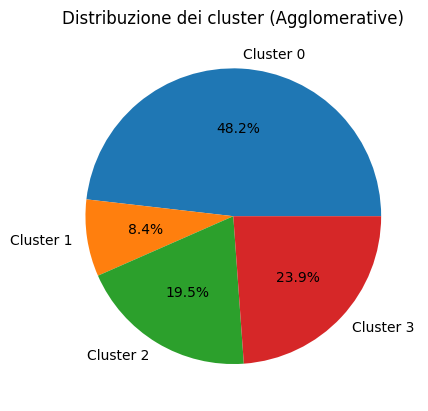

In [18]:
clust_sizes_agg = np.unique(agg_labels, return_counts=True)
# pie chart
plt.pie(
    clust_sizes_agg[1],
    labels=[f"Cluster {i}" for i in clust_sizes_agg[0]],
    autopct='%1.1f%%', # percentuali delle fette
)
plt.title("Distribuzione dei cluster (Agglomerative)")
plt.show()

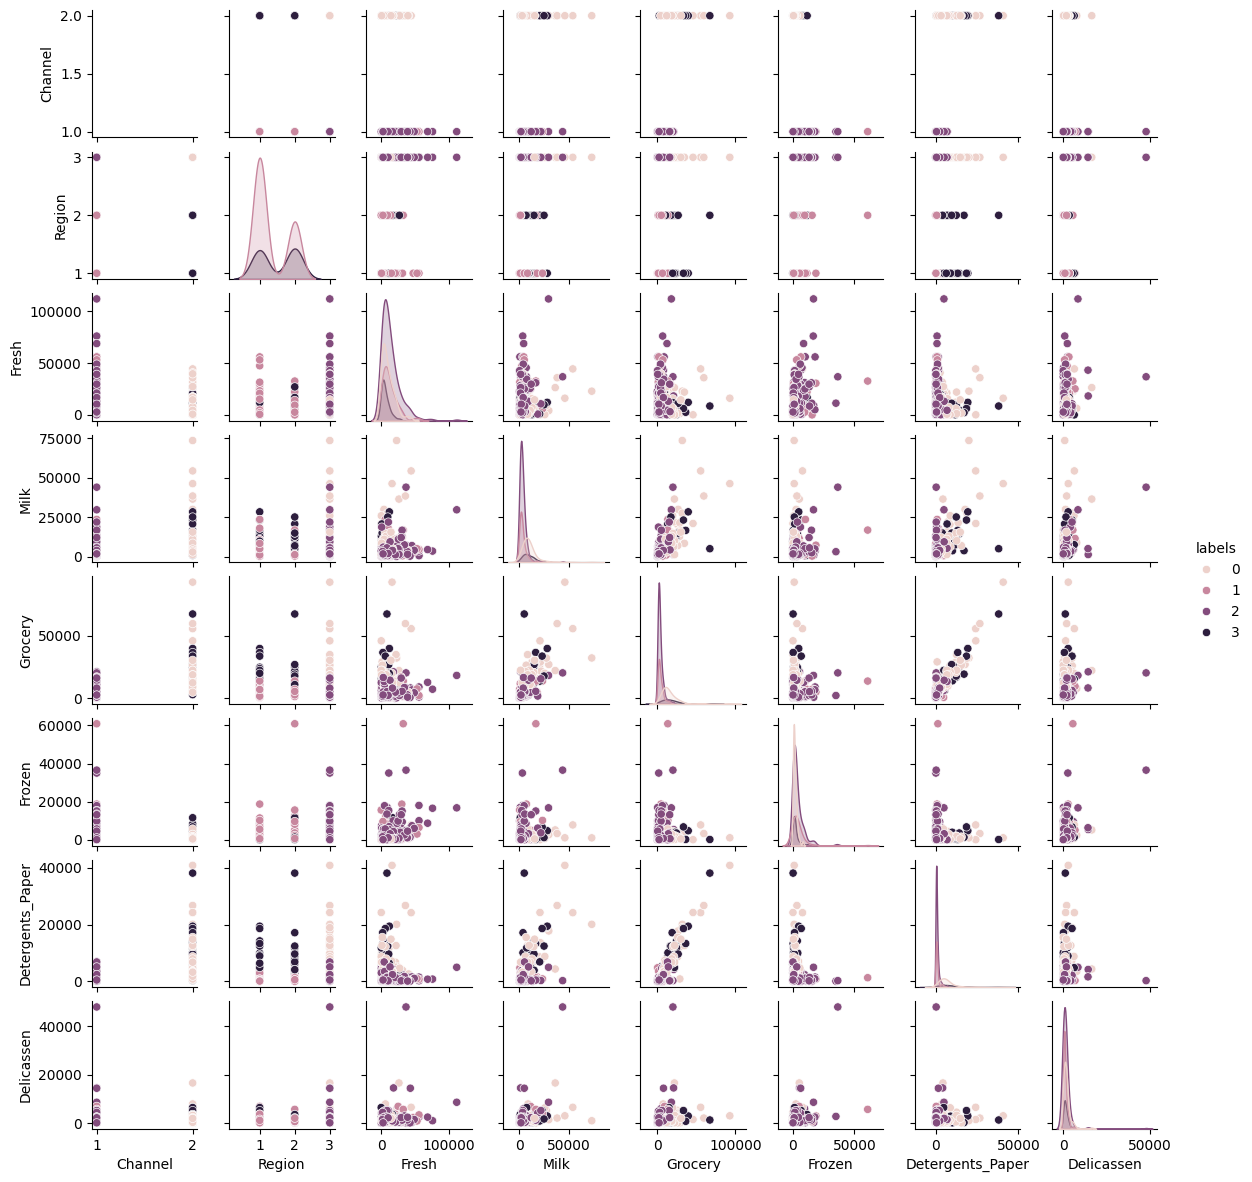

In [24]:
df_km = df.copy()
df_km["labels"] = km_labels

target = "labels"
sns.pairplot(df_km, hue=target, height=1.5)

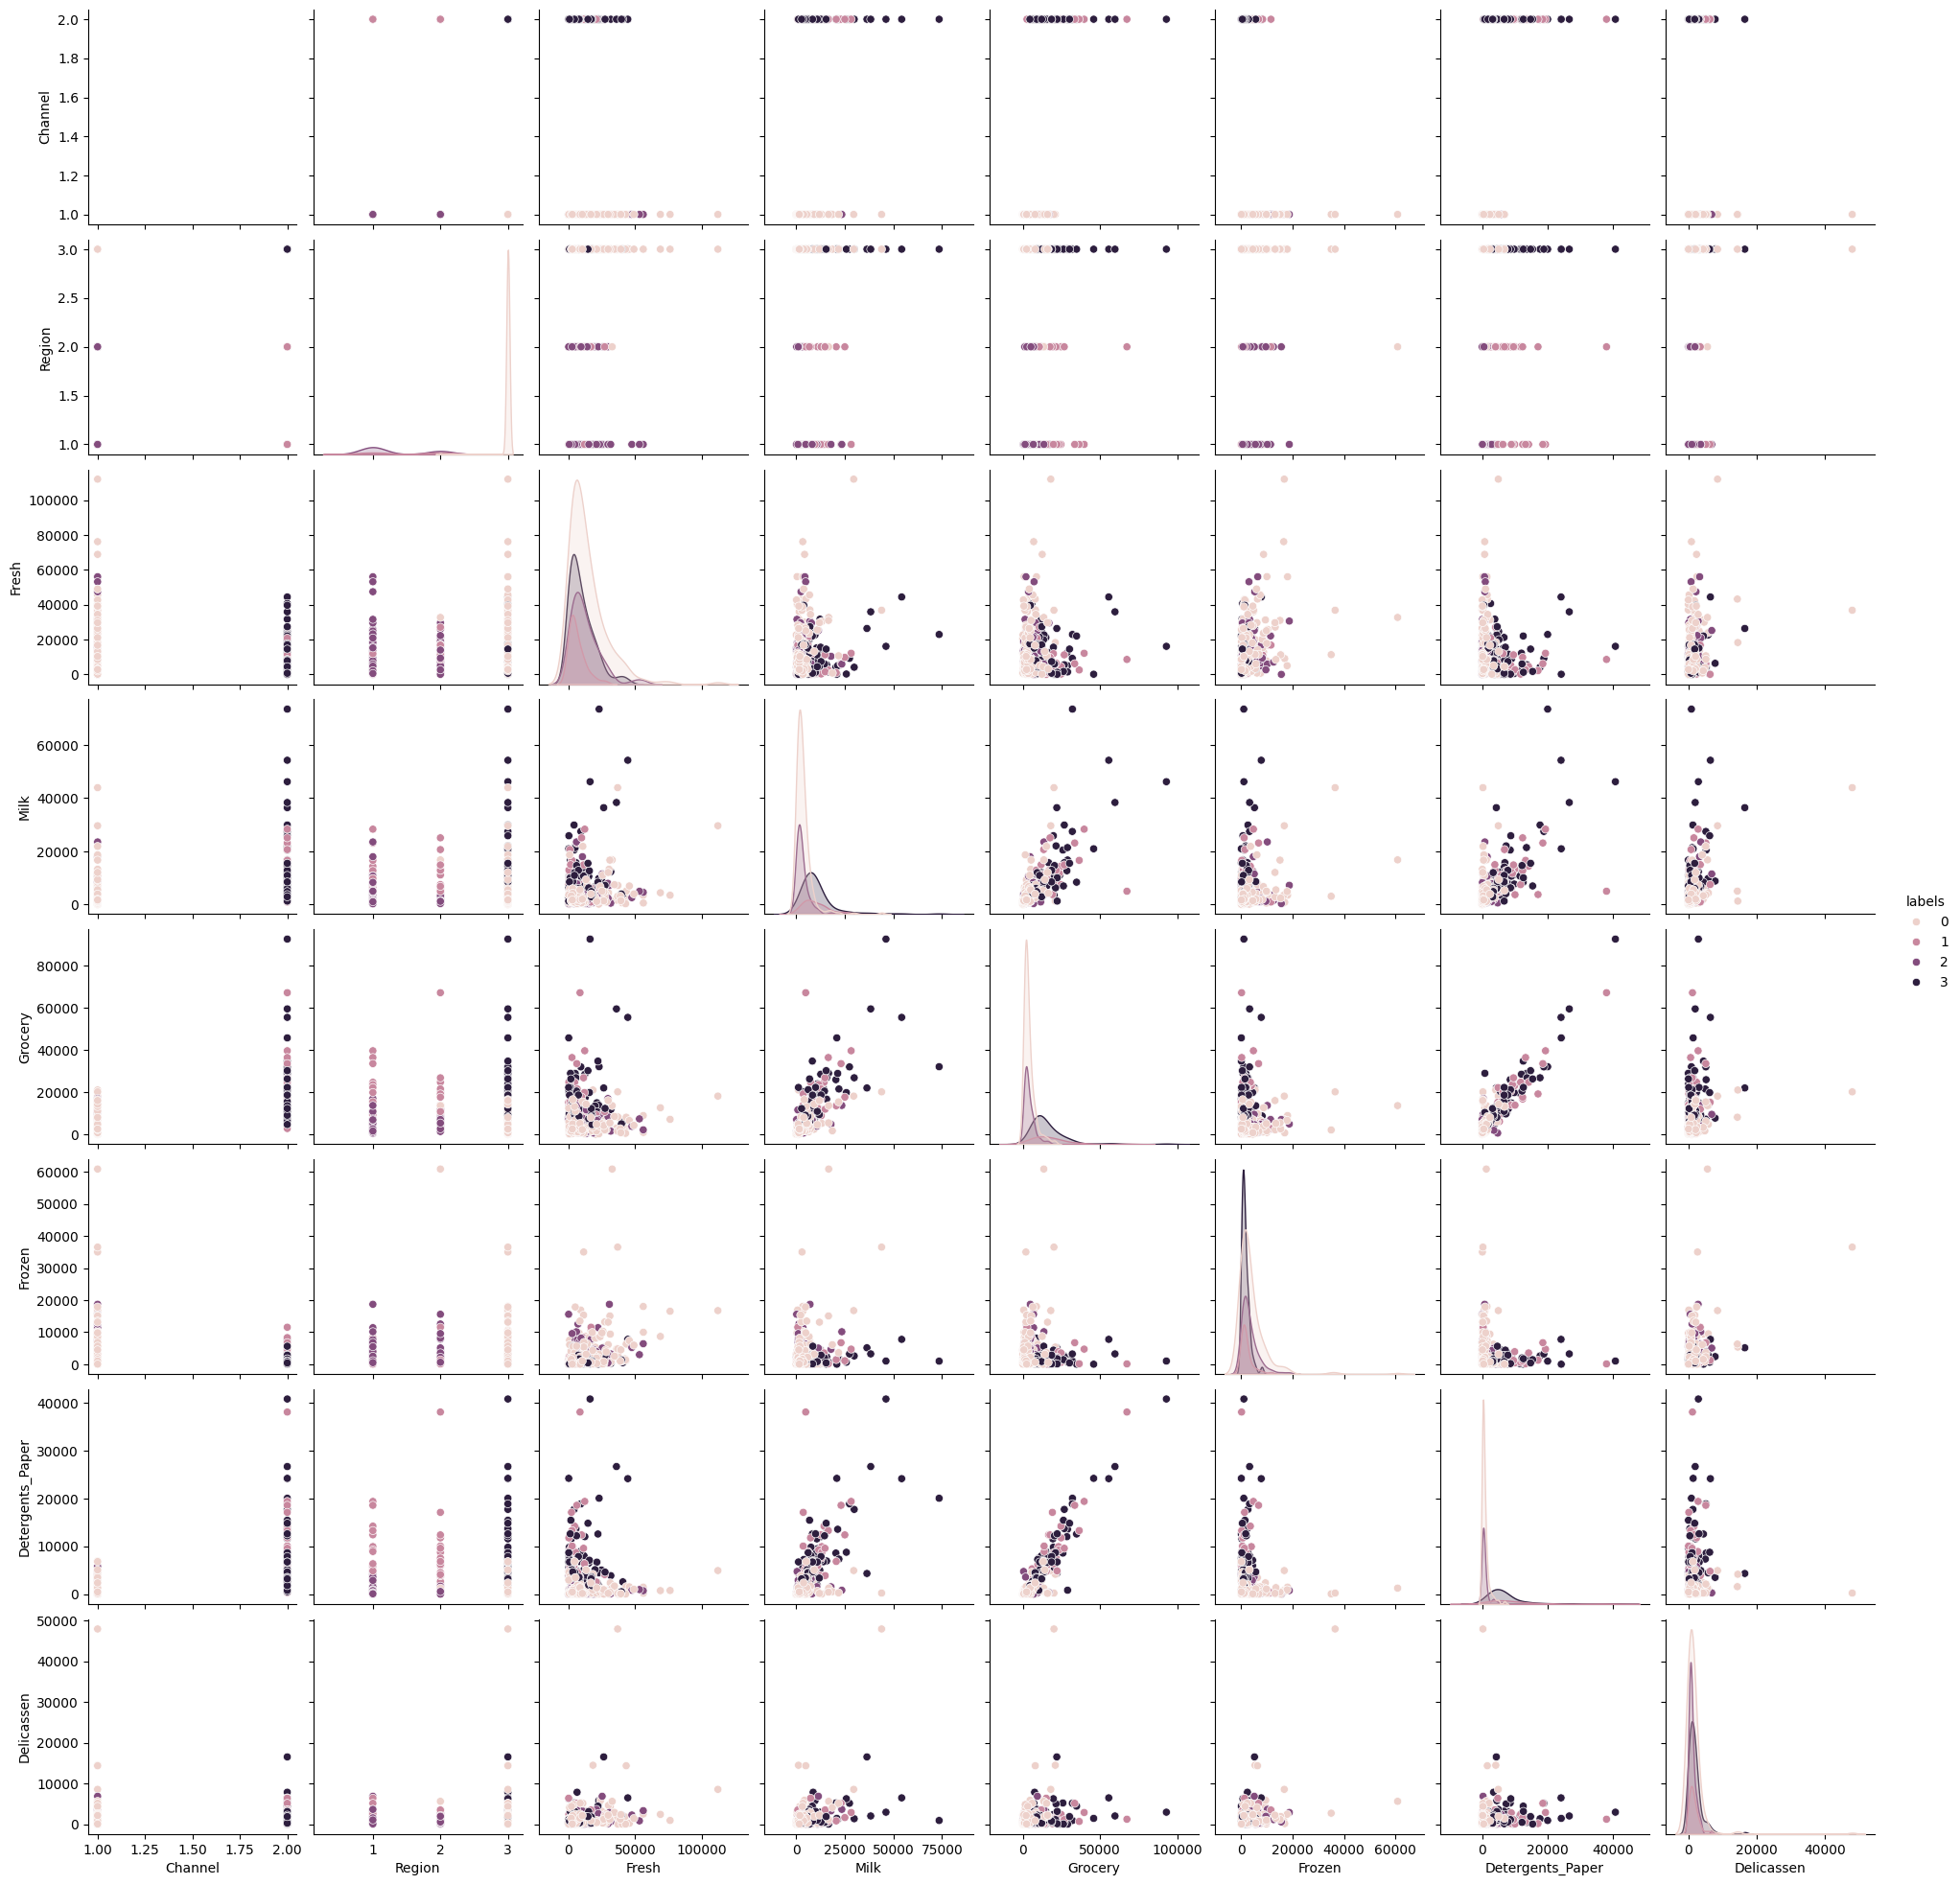

In [21]:
df_agg = df.copy()
df_agg["labels"] = agg_labels

target = "labels"
sns.pairplot(df_agg, hue=target)

### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [79]:
from sklearn.metrics import pair_confusion_matrix

confusion_matrix = pair_confusion_matrix(km_labels, agg_labels) 
tot = np.asarray(pair_confusion_matrix(km_labels, agg_labels)).sum()
confusion_matrix = confusion_matrix / tot
confusion_matrix

array([[0.66625595, 0.00218472],
       [0.00089045, 0.33066888]])

A short indicator of the match percentage can be optained as a sum of the elements of the main diagonal.

In [83]:
print(f"Abbiamo un match del {(confusion_matrix[0,0]+confusion_matrix[1,1]) * 100:.2f} % tra i due clustering scheme")

Abbiamo un match del 99.69 % tra i due clustering scheme


## DBSCAN

In [26]:
from sklearn.cluster import DBSCAN


In [36]:
eps = 0.5
min_samples = 5
print(f"Default parameters - Eps={eps} - Min_Samples={min_samples}")

db = DBSCAN(eps, min_samples=min_samples)
db_labels = db.fit_predict(transformed_df)

Default parameters - Eps=0.5 - Min_Samples=5


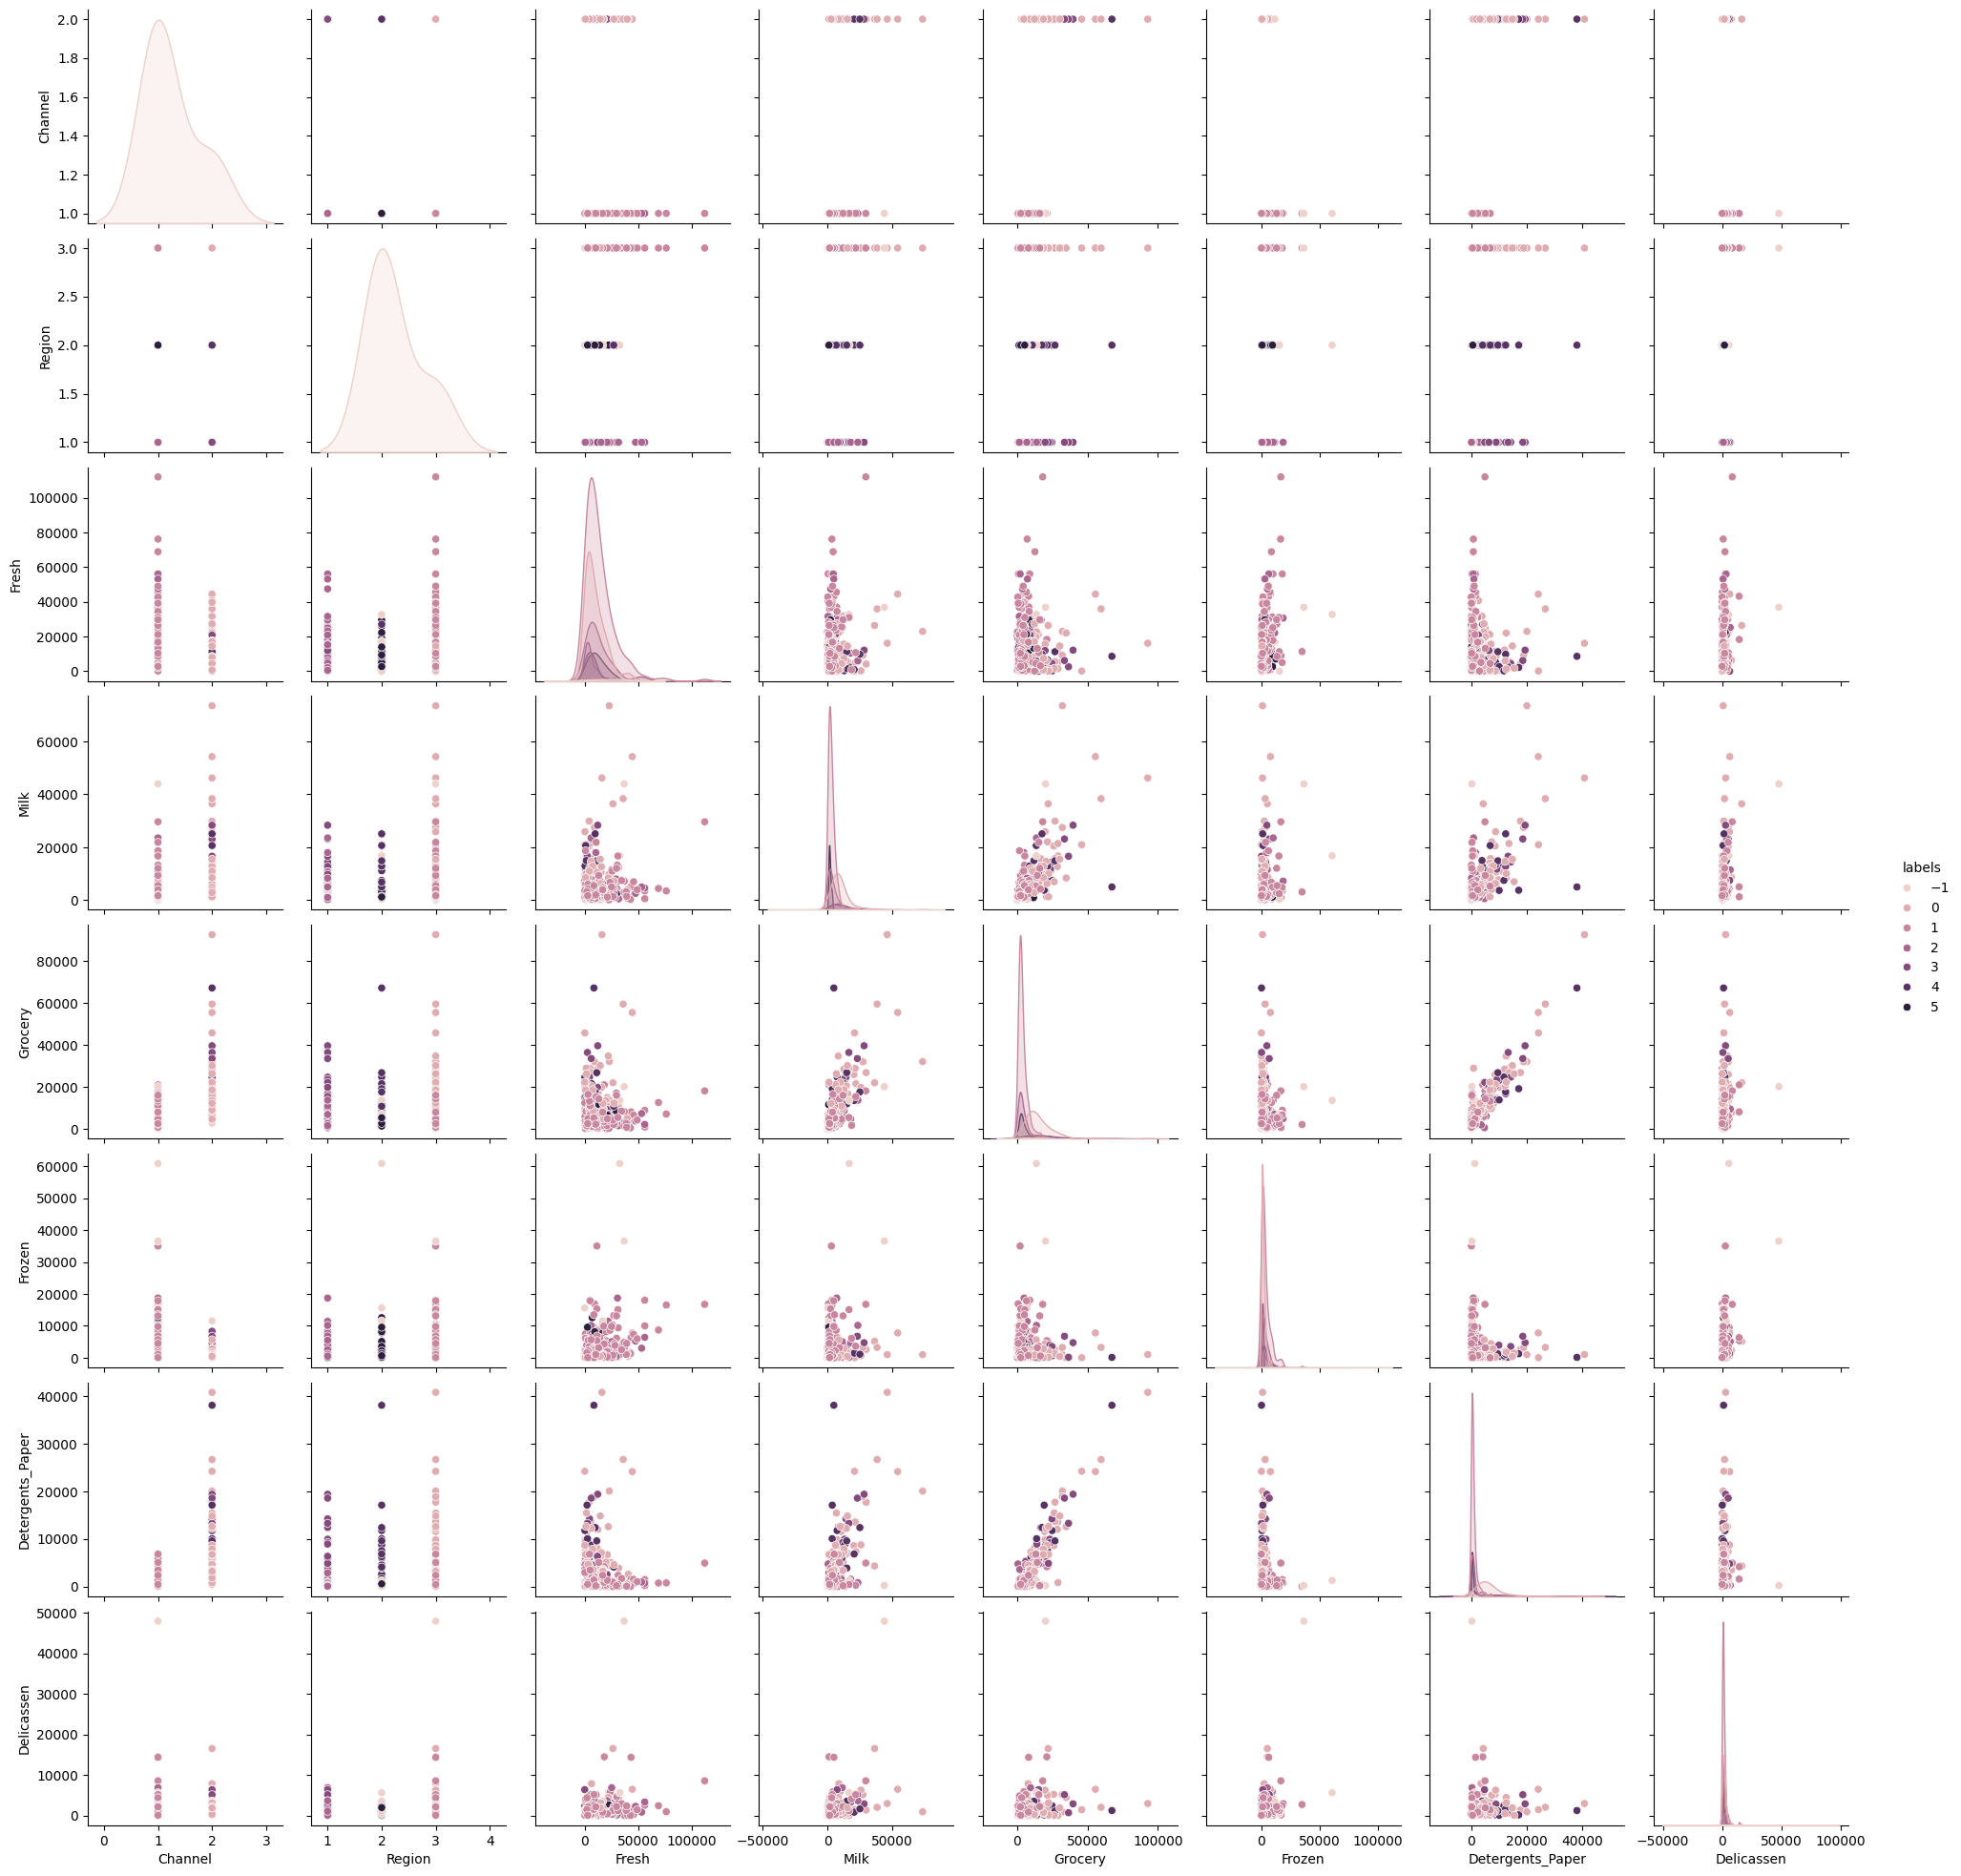

In [37]:
df_db = df.copy()
df_db["labels"] = db_labels

target = "labels"
sns.pairplot(df_db, hue=target)

Show the distribution of data in the clusters

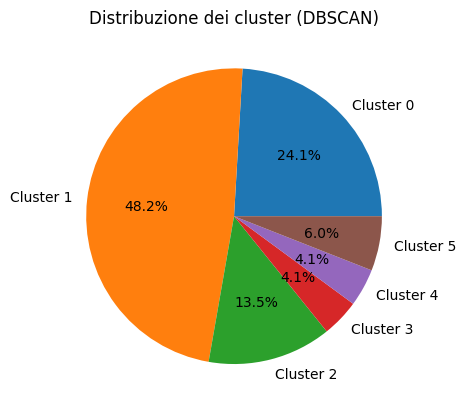

In [47]:
# pie chart
plt.pie(
    clust_sizes_db[1],
    labels=[f"Cluster {i}" for i in clust_sizes_db[0]],
    autopct='%1.1f%%', # percentuali delle fette
)
plt.title("Distribuzione dei cluster (DBSCAN)")
plt.show()

### 5. Find the best parameters using `ParameterGrid`

prepare the dictionary of the parameter ranges and produce the list of parameter settings to test with the function `ParameterGrid`

In [84]:
cluster_range = range(2,11)
epsilon_range = np.arange(0.1, 0.6, 0.05)
min_samples_range = range(2, 10)

parameters = [{
    "n_clusters": cluster_range,
    "eps": epsilon_range,
    "min_samples": min_samples_range
}]
pg = ParameterGrid(parameters)

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

`dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])`

- for each parameter setting

In [88]:
results = pd.DataFrame(columns=["eps", "min_samples", "n_clusters", "silhouette", "unclust%"])

tot = len(transformed_df)
for parameter_conf in pg:
    db = DBSCAN(parameter_conf["eps"], min_samples=parameter_conf["min_samples"])
    db_labels = db.fit_predict(transformed_df)
    
    unclust_percentage = len(db_labels[db_labels != -1]) / tot

    try:
        sil = silhouette_score(transformed_df, db_labels)
    except Exception:
        # skip se silhouette_score fallisce
        continue
        
    results.loc[len(results)] = [
        parameter_conf["eps"],
        parameter_conf["min_samples"],
        parameter_conf["n_clusters"],
        sil,
        unclust_percentage
    ]

In [89]:
results

eps  min_samples  n_clusters  silhouette  unclust%
0    0.10          2.0         2.0   -0.485338  0.197727
1    0.10          2.0         3.0   -0.485338  0.197727
2    0.10          2.0         4.0   -0.485338  0.197727
3    0.10          2.0         5.0   -0.485338  0.197727
4    0.10          2.0         6.0   -0.485338  0.197727
..    ...          ...         ...         ...       ...
688  0.55          9.0         6.0    0.398375  0.995455
689  0.55          9.0         7.0    0.398375  0.995455
690  0.55          9.0         8.0    0.398375  0.995455
691  0.55          9.0         9.0    0.398375  0.995455
692  0.55          9.0        10.0    0.398375  0.995455

[693 rows x 5 columns]

In [90]:
results_sorted = results.sort_values(by="silhouette", ascending=False)
results_sorted

eps  min_samples  n_clusters  silhouette  unclust%
675  0.55          8.0         2.0    0.398375  0.995455
692  0.55          9.0        10.0    0.398375  0.995455
691  0.55          9.0         9.0    0.398375  0.995455
690  0.55          9.0         8.0    0.398375  0.995455
674  0.55          7.0        10.0    0.398375  0.995455
..    ...          ...         ...         ...       ...
8    0.10          2.0        10.0   -0.485338  0.197727
4    0.10          2.0         6.0   -0.485338  0.197727
5    0.10          2.0         7.0   -0.485338  0.197727
1    0.10          2.0         3.0   -0.485338  0.197727
0    0.10          2.0         2.0   -0.485338  0.197727

[693 rows x 5 columns]

### 6. Observe  
- Observe visually the most promising combination of parameters reproducing the same number of clusters of the previous experiments 
- fit and predict the cluster labels and show a pairplot

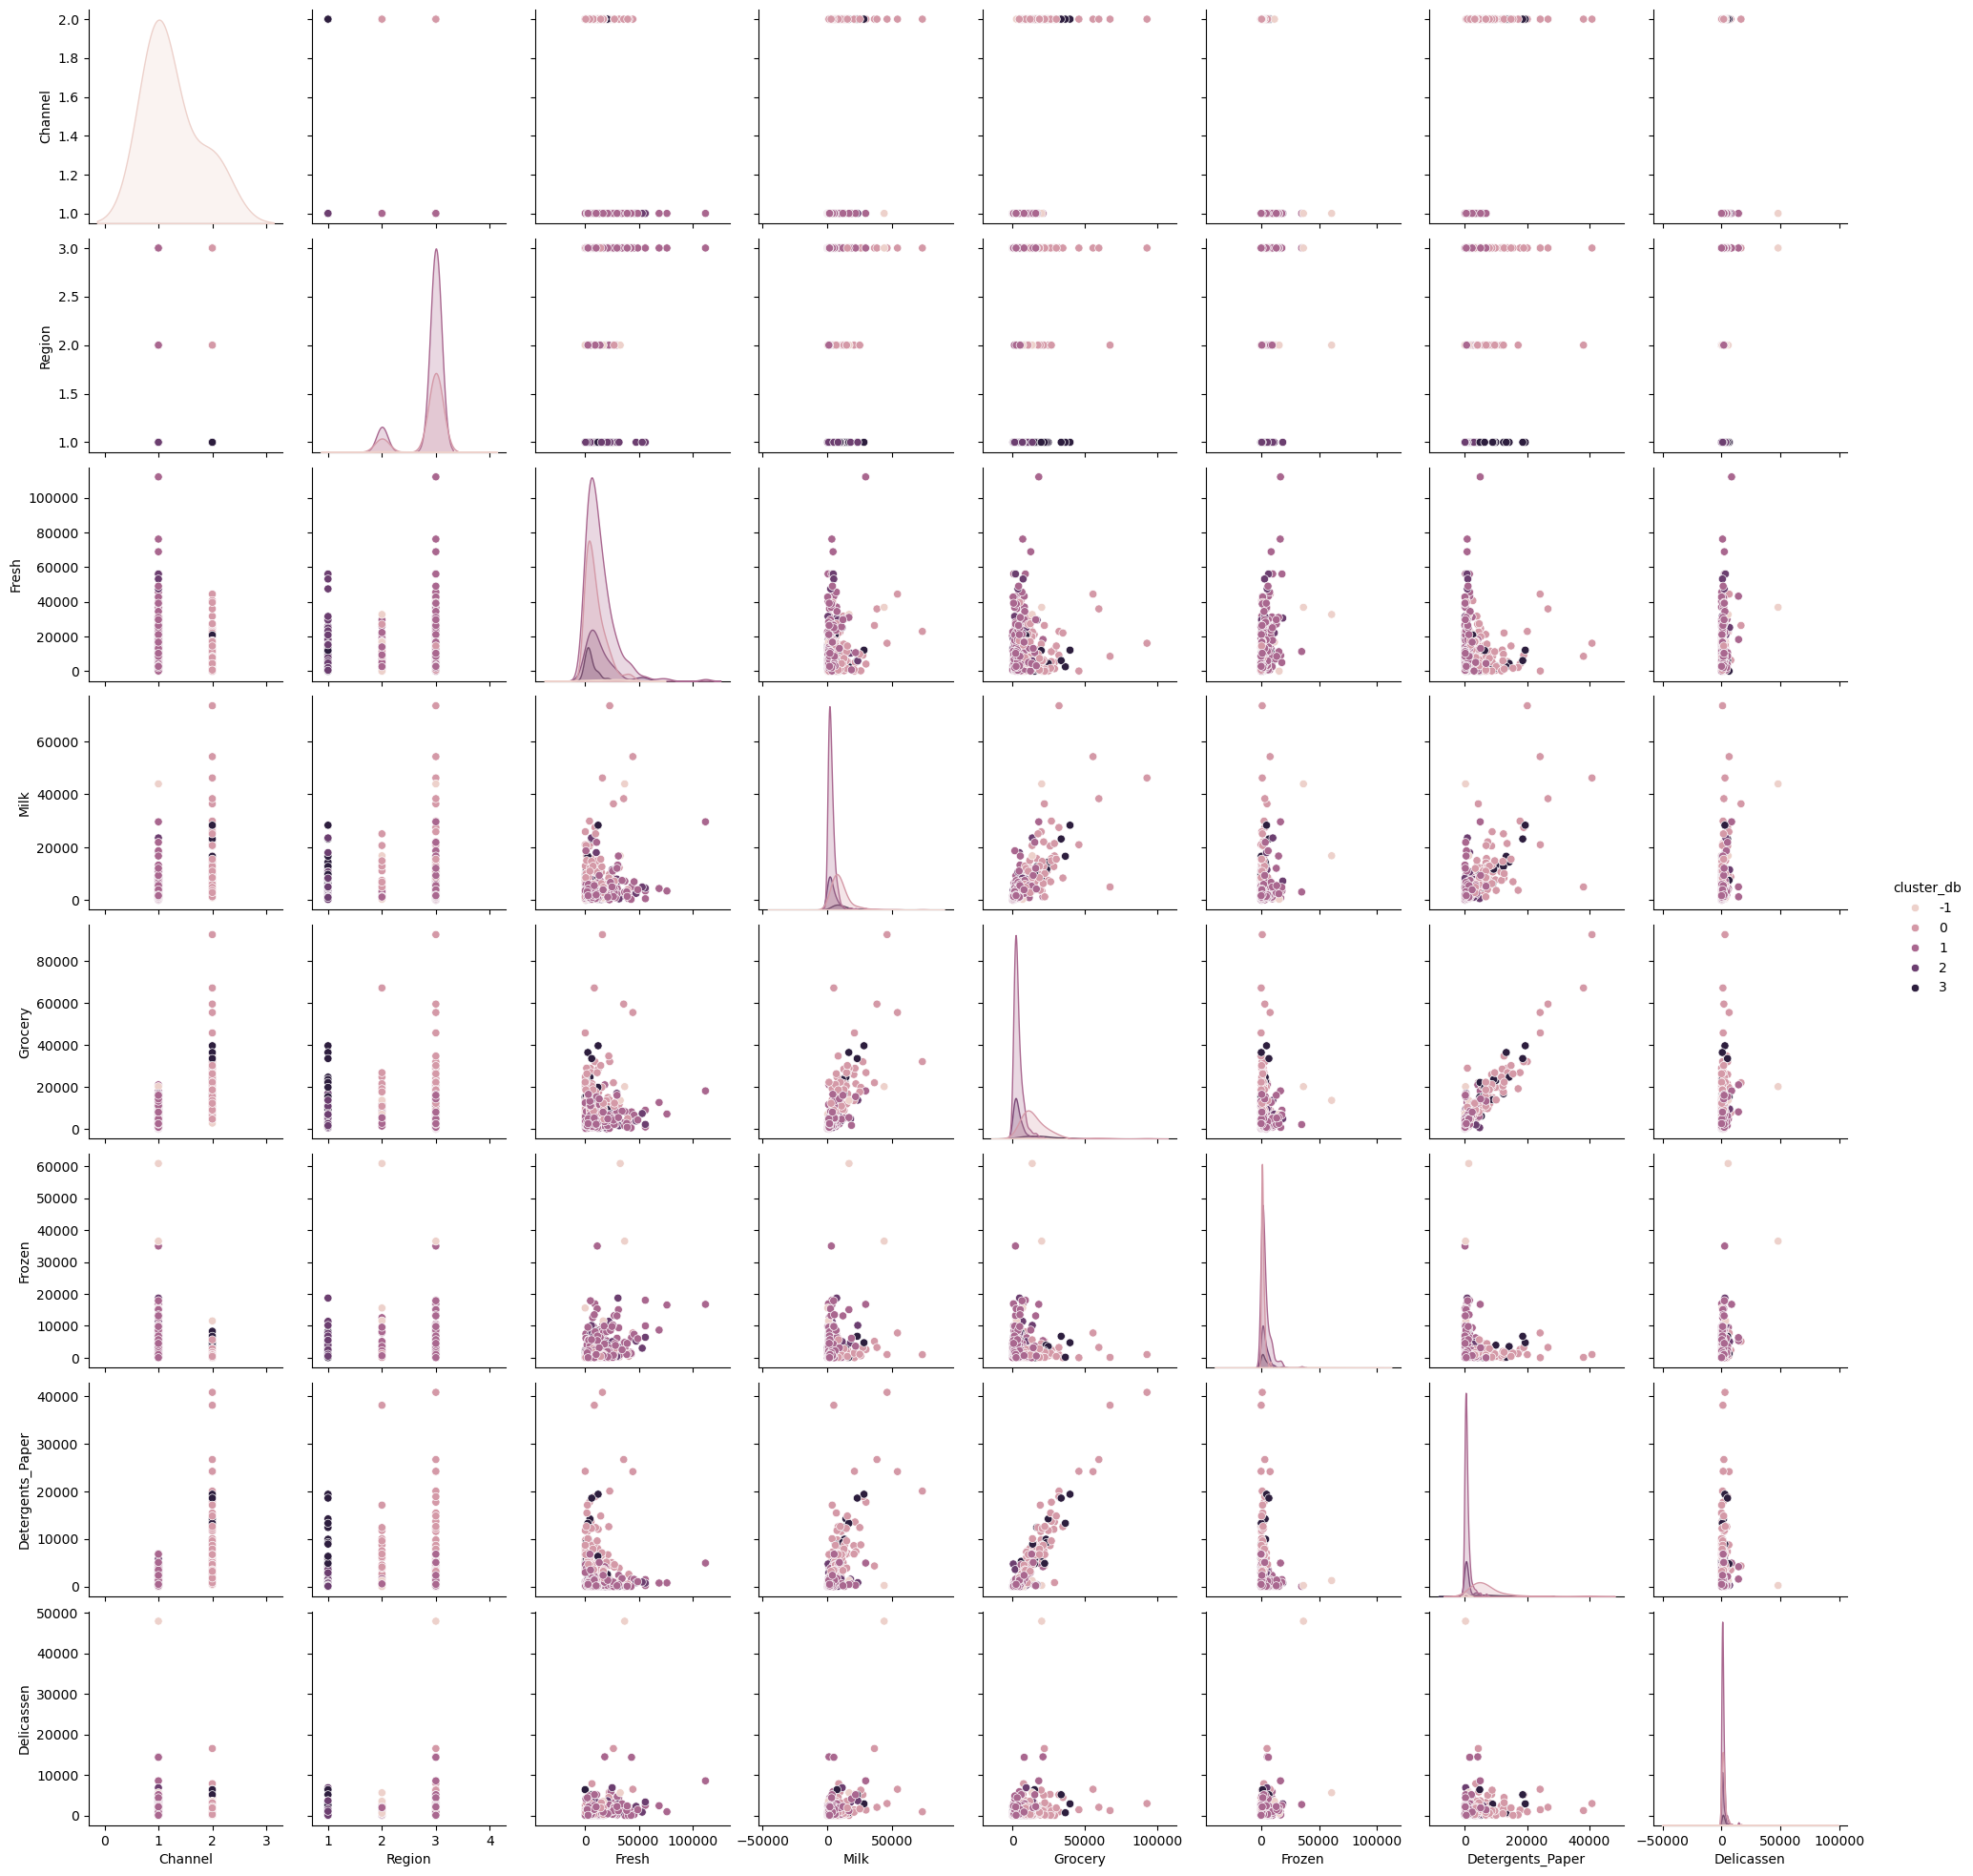

Show the cluster sizes

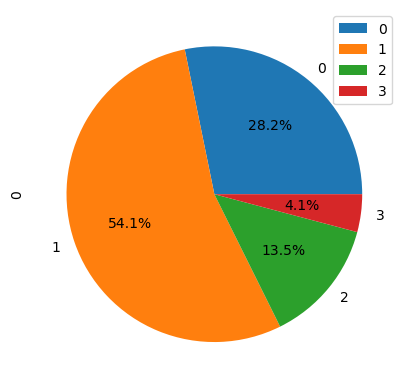

## Silhouette plots

Use the function `plot_silhouette` contained in the module `plot_silhouette_w_mean` (provided with the notebook) and from `sklearn.metrics` import the function `silhouette_samples` providing the silhouette score for each sample

`from plot_silhouette_w_mean import plot_silhouette  # python script provided separately`

Hint: use `help(plot_silhouette)` for the meaning of the parameters

Hint: for DBSCAN you should exclude the rows of noise

In [49]:
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately
help(plot_silhouette)

Help on function plot_silhouette in module plot_silhouette_w_mean:

plot_silhouette(
    silhouette_vals,
    y,
    colors=<matplotlib.colors.ListedColormap object at 0x7f385acbcc50>,
    plot_noise=False
)
    Plotting silhouette scores for the individual samples of a labelled data set.
    The scores will be grouped according to labels and sorted in descending order.
    The bars are proportional to the score and the color is determined by the label.

    silhouette_vals: the silhouette values of the samples
    y:               the labels of the samples
    plot_noise:      boolean, assumes the noise to be labeled with a negative integer



## Optional - Comparison with __boxplots__

For each of the clustering schemes show how the attribute values are distributed in the clusters

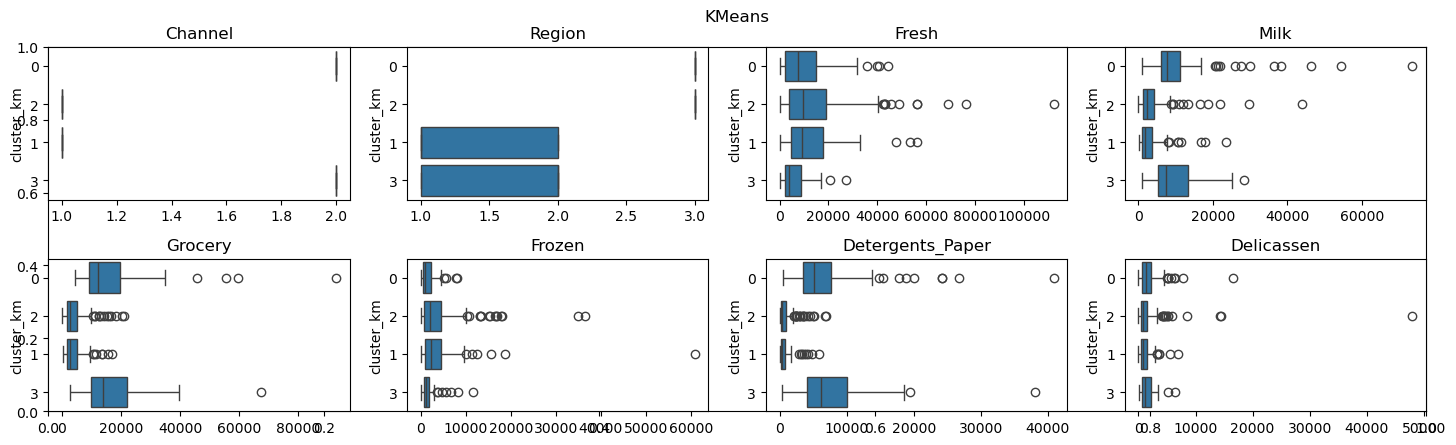

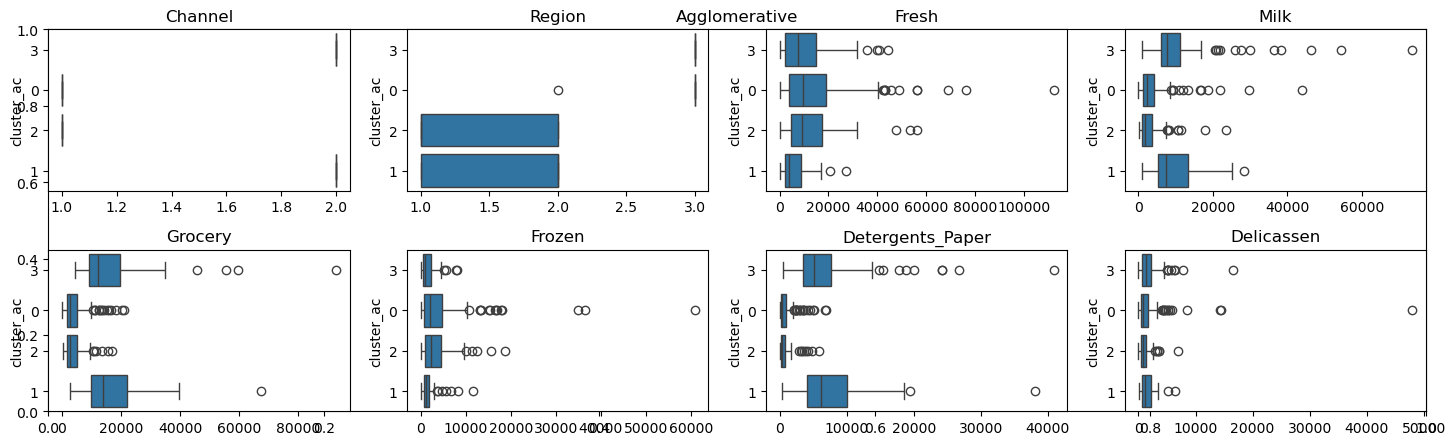

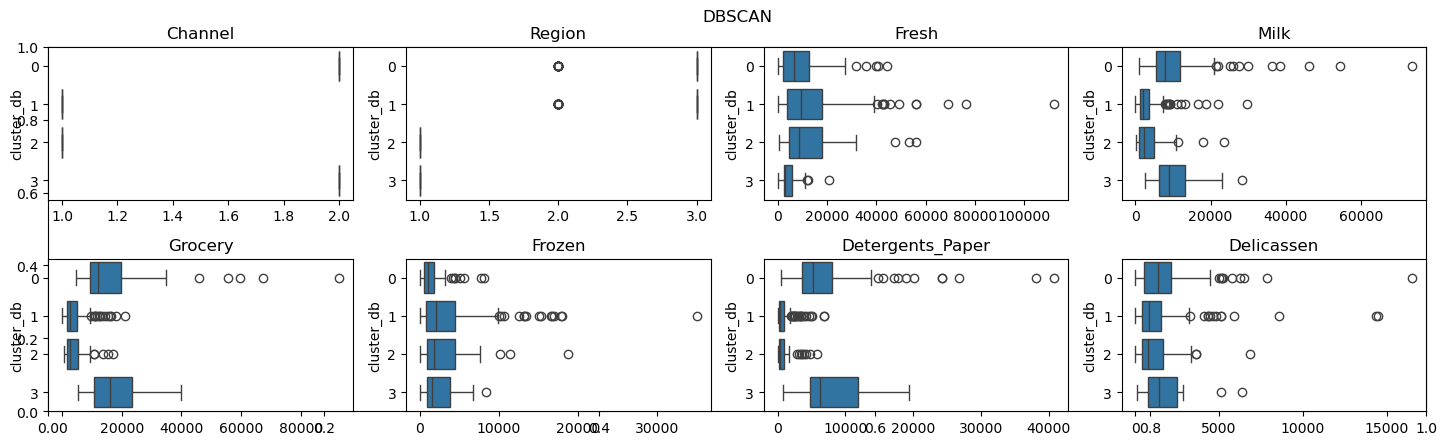

## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results